In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets,transforms
from torchvision.utils import make_grid
from torchsummary import summary
from torch.autograd.gradcheck import zero_gradients

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:

transform=transforms.ToTensor()
train_data=datasets.MNIST(root="./",train=True,download=True,transform=transform)
test_data=datasets.MNIST(root="./",train=False,download=True,transform=transform)
train_loader=DataLoader(train_data,batch_size=64,shuffle=True)
test_loader=DataLoader(test_data,batch_size=64,shuffle=False)
device = 'cuda'

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.bn2 = nn.BatchNorm2d(64)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.bn1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.bn2(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

In [ ]:
model =CNN().to('cuda')
summary(model,(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
       BatchNorm2d-2           [-1, 32, 26, 26]              64
            Conv2d-3           [-1, 64, 24, 24]          18,496
       BatchNorm2d-4           [-1, 64, 24, 24]             128
         Dropout2d-5           [-1, 64, 12, 12]               0
            Linear-6                  [-1, 128]       1,179,776
         Dropout2d-7                  [-1, 128]               0
            Linear-8                   [-1, 10]           1,290
Total params: 1,200,074
Trainable params: 1,200,074
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.96
Params size (MB): 4.58
Estimated Total Size (MB): 5.55
----------------------------------------------------------------


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [ ]:
#FOR LOOP EPOCHS
import time
start_time = time.time()


#VARIABLES,TRACKERS


epochs = 10
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):


  trn_corr = 0
  tst_corr = 0

  for j,(X_train,y_train) in enumerate(train_loader):
    
    j+=1

    #TRAIN
    X_train = X_train.to(device)
    y_train = y_train.to(device)

    y_pred = model(X_train)
    loss = criterion(y_pred,y_train)

    predicted = torch.max(y_pred.data,1)[1]

    batch_corr = (predicted == y_train ).sum() 
    trn_corr+=batch_corr

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if j% 250== 0:
      print(f'epoch {i} : batch  {j} : loss {loss.item()}')


  train_losses.append(loss)
  train_correct.append(trn_corr) 

      
    #TEST
  with torch.no_grad():

    for i,(X_test,y_test) in enumerate(test_loader):
    
      i+=1
      X_test = X_test.to(device)
      y_test = y_test.to(device)
      y_tpred = model(X_test)
      loss = criterion(y_tpred,y_test)
      predicted = torch.max(y_tpred.data,1)[1]

      batch_corr = (predicted == y_test ).sum() 
      tst_corr+=batch_corr


  test_losses.append(loss)
  test_correct.append(tst_corr) 



current_time = time.time()
print(f'the model took {(current_time-start_time)/60} minutes to train')

epoch 0 : batch  250 : loss 0.07129345089197159
epoch 0 : batch  500 : loss 0.20709306001663208
epoch 0 : batch  750 : loss 0.27893754839897156
epoch 1 : batch  250 : loss 0.2802373468875885
epoch 1 : batch  500 : loss 0.00905406940728426
epoch 1 : batch  750 : loss 0.14671647548675537
epoch 2 : batch  250 : loss 0.031407952308654785
epoch 2 : batch  500 : loss 0.03336367756128311
epoch 2 : batch  750 : loss 0.05360788479447365
epoch 3 : batch  250 : loss 0.09162218123674393
epoch 3 : batch  500 : loss 0.26557445526123047
epoch 3 : batch  750 : loss 0.10017894953489304
epoch 4 : batch  250 : loss 0.02234411984682083
epoch 4 : batch  500 : loss 0.01564454846084118
epoch 4 : batch  750 : loss 0.18391233682632446
epoch 5 : batch  250 : loss 0.0748198926448822
epoch 5 : batch  500 : loss 0.1855126917362213
epoch 5 : batch  750 : loss 0.040131088346242905
epoch 6 : batch  250 : loss 0.014782640151679516
epoch 6 : batch  500 : loss 0.0752338171005249
epoch 6 : batch  750 : loss 0.00872967671

Test accuracy Basic: 9779/10000 =  97.790%


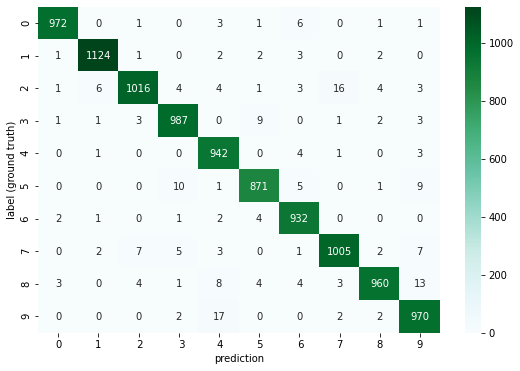

In [ ]:
test_load_all = torch.utils.data.DataLoader(test_data, batch_size=10000, shuffle=False)

with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        X_test = X_test.to(device)
        y_test = y_test.to(device)
        y_val = model(X_test)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
        
print(f'Test accuracy Basic: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')

class_names = ['0', '1', ' 2', '  3', ' 4', ' 5', ' 6', '7', '8', '9']
arr = confusion_matrix(predicted.view(-1).cpu(), y_test.view(-1).cpu())
df_cm = pd.DataFrame(arr, class_names, class_names)


plt.figure(figsize = (9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show()

In [ ]:
dummy_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False)
#objective : train a adversarial model to misclassify a image of a number as "3"(say).
# sample a image from test_loader
for img, label in dummy_loader:
  break  

tensor([7])
the prediction now is 7


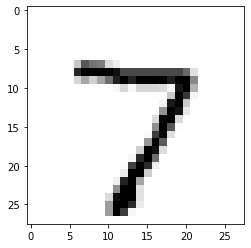

In [ ]:
plt.imshow(img.cpu().detach().reshape(28,28),cmap='Greys') # we'll make 7 to be misclassified here
y_pred = model(img.to(device))
print(label)
predicted = torch.max(y_pred.data,1)[1]
print(f'the prediction now is {predicted.item()}')
target = torch.zeros((1),dtype=torch.int64,device=device)#create target
target[0]=3

In [ ]:
img = img.to(device)
base = img # to compare with the loss function
img.requires_grad_(True); # to enable changing the image
#img.retain_grad() #retain the gradient sice its not a leaf node.

In [ ]:
pixel_criterion = nn.MSELoss()
class_criterion = nn.CrossEntropyLoss()

In [ ]:
#attack starts here 
iter =50
eps =0.01
for i in range(iter):

  #print(img.grad.data)
  pred = model(img)
  loss = class_criterion(pred,target) + pixel_criterion(base,img)
  if i%10==0:

    print(f'pixel_loss : {pixel_criterion(base,img)},class criterion = {class_criterion(pred,target)}')
  loss.backward()
  with torch.no_grad():
    
    img-=eps*img.grad
    img = torch.clamp(img,0,1)
    img.requires_grad_(True)

  
  zero_gradients(img)

pixel_loss : 0.0022594851907342672,class criterion = 0.023712150752544403
pixel_loss : 0.0026878120843321085,class criterion = 0.0009149893885478377
pixel_loss : 0.002688103122636676,class criterion = 4.5536911784438416e-05
pixel_loss : 0.0026854167226701975,class criterion = 0.001258177449926734
pixel_loss : 0.0026801491621881723,class criterion = 0.00011002412065863609


tensor([3], device='cuda:0')


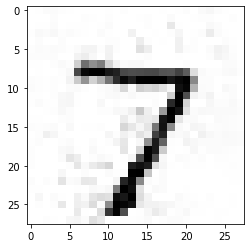

In [ ]:
plt.imshow(img.detach().cpu().reshape(28,28),cmap='Greys')
y_pred = model(img)
predicted = torch.max(y_pred.data,1)[1]
print(predicted)